# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
NAME = 'fashion_mnist'

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [5]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## preview test data

Ankle boot


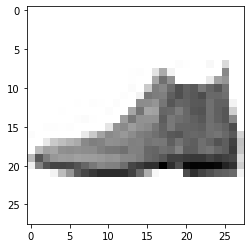

In [6]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')

## train the model

In [7]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 12s 206us/sample - loss: 0.5011 - accuracy: 0.8234


# Define & save BentoService

In [22]:
%%writefile tensorflow_fashion_mnist.py

import random
import time
import base64

import bentoml
import tensorflow as tf

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler, ClipperStringsHandler


try:
    tf.config.set_visible_devices([], 'GPU')  # disable GPU, required when served in docker
except:
    pass


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


#@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler, mb_max_latency=300)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

    @bentoml.api(ClipperStringsHandler)
    def predict_clipper(self, strings):
        _bytes = [base64.b64decode(i) for i in strings]
        inputs = tf.constant(_bytes, dtype=tf.string)
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [23]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

INFO:tensorflow:Assets written to: /tmp/bentoml-temp-ur19fcpd/FashionMnistTensorflow/artifacts/model_saved_model/assets
[2020-05-15 08:05:23,774] INFO - BentoService bundle 'FashionMnistTensorflow:20200515080454_CEC50C' saved to: /home/ec2-user/bentoml/repository/FashionMnistTensorflow/20200515080454_CEC50C


# Build & Run Bento Service

In [26]:
!cd {saved_path}
!docker build -t {NAME} {saved_path}

Sending build context to Docker daemon  1.356MB
Step 1/18 : FROM continuumio/miniconda3:4.8.2
 ---> b4adc22212f1
Step 2/18 : RUN set -x      && apt-get update      && apt-get install --no-install-recommends --no-install-suggests -y libpq-dev build-essential      && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 699866880415
Step 3/18 : RUN conda install pip numpy scipy       && pip install gunicorn
 ---> Using cache
 ---> 425a8b5aec98
Step 4/18 : COPY . /bento
 ---> 58f868c3485a
Step 5/18 : WORKDIR /bento
 ---> Running in 9e78ef17e9be
Removing intermediate container 9e78ef17e9be
 ---> 4e9a86594dee
Step 6/18 : RUN if [ -f /bento/setup.sh ]; then /bin/bash -c /bento/setup.sh; fi
 ---> Running in c2861ea4b991
Removing intermediate container c2861ea4b991
 ---> 7c26be720600
Step 7/18 : RUN conda env update -n base -f /bento/environment.yml
 ---> Running in bed06029784e
Solving environment: ...working... done

pycparser-2.20       | 92 KB     | ########## | 100% 
urllib3-1.25.8       | 

### Run with docker

In [1]:
NAME = 'fashion_mnist'

In [2]:
from bentoml.utils import detect_free_port
PORT = detect_free_port()
print(PORT)
server_url = f'http://127.0.0.1:{PORT}/predict'

47963


In [15]:
!docker run -itd -p {PORT}:5000 20200515080454_cec50c:latest --workers 1 --enable-microbatch

998a5cbe666fca5535736f75cf1e4cf8c3a9700dc2fc7e225158f4045c2d2631


### or run with command bellow

In [13]:
print(f'bentoml serve-gunicorn {saved_path} --port {PORT} --enable-microbatch --workers 1')

bentoml serve-gunicorn /home/ec2-user/bentoml/repository/FashionMnistTensorflow/20200515073337_BF6721 --port 59769 --enable-microbatch --workers 1


# generate test requests

In [5]:
import tensorflow as tf
from io import BytesIO
import matplotlib.pyplot as plt
import base64
import json
import random


def get_request_producer():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    url = server_url
    method = "POST"
    headers = {"content-type": "application/json"}
    pred_sentence =  "The acting was a bit lacking."

    def _gen_data(size=1):
        sio = BytesIO()
        
        d_test_img = _test_images[random.randint(0, len(_test_images))]
        label = class_names[test_labels[0]]
        plt.imsave(sio, 255.0 - d_test_img, cmap='gray')
        img_bytes = sio.getvalue()
    
        img_b64 = base64.b64encode(img_bytes).decode()

        data = json.dumps(
               {"instances": [{"b64": img_b64}] * size}
        )
        return url, method, headers, data

    return _gen_data

# test
get_request_producer()(1)

('http://127.0.0.1:47963/predict',
 'POST',
 {'content-type': 'application/json'},
 '{"instances": [{"b64": "iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAYAAAByDd+UAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAAPYQAAD2EBqD+naQAABXlJREFUSImNlktvEu8Xxz9zBQbq2AKxhSYtJaat1Zh4iZe4YefOaKILXZj4NnwNLnwtJu76CppUY0yNFAWrJci14DD3y3/Bn4n+wNqzmYSZ53zO+T7nghBFUcRvFkURgiAAMBqNePXqFWtra7x48YK/mW3bvH79msXFRZ4/f04ikfjrt8J/gVN7+/Yt3W6Xo6Mj9vf3sW2bu3fvsr6+ztbWFgCHh4fs7e1xfHzMxsYGt2/fptFocP/+fTY3NwnDEFEU//Arz4N1Oh0ODw8plUpcunSJXq9HIpHAdV329/cBcF2XDx8+oOs6uq5TLpfJ5/NYlsXu7i6bm5szMIDZX4B6vY6iKDiOQ7PZ5PHjx+TzeQzDYHV1lUajQa1WY2lpiSiKqFQqbG1t0Wg0EAQBz/P48ePHXEnnZjgajQiCAADTNPny5QtXr15FVVX29vYA8H2ffD7PnTt3WF5e5uvXryiKQhiGSJJEp9NhdXX17EAAz/PiAur1ely+fJmLFy/y7ds3zp8/T7FYZDQa8f37dxRFwbZtFEVhPB4zHA7PnuHJyQmyLON5HplMBlVVEQSBfr+Ppmns7Ozg+z7dbhfP80in07iuG1+DLMt0u92zA8fjMQCWZZFMJgnDkEQiQRiGWJaF67q4rovjOARBQBiGyPLElWEYiKIY+zgTMAxDHMdBURQ0TaPZbAKgKAqSJKEoCkEQ4Lpu/Dx37hypVIrhcEgymaTf788FzlTpyckJjuPgui7VahVBEEgmkyiKgiAIBEGAaZp4njeJWJYRRRFN07Asi3q

## Test with requests

In [6]:
import requests
url, _, headers, data = get_request_producer()()
json_response = requests.post(url, data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
["Sneaker"]


## Benchmark

In [7]:
import os


def init_file(file_name):
    if os.path.exists(LOG_FILE):
        return
    with open(file_name, "a") as lf:
        lf.write('"model name","test_users","total succ","succ/sec","avg resp time",'
                 '"total fail","fail/sec","avg fail resp time","client health"')
        lf.write('\n')


def log_result(b, name, file_name, test_user):
    init_file(file_name)
    self = b.stat

    result = []
    result.append(name)
    result.append(test_user)
    result.append(self.success)
    result.append(self.success / max(self.sess_time, 1))
    result.append(sum(self.succ_times) / max(self.success, 1))

    result.append(self.fail)
    result.append(self.fail / max(self.sess_time, 1))
    result.append(sum(self.exec_times) / max(self.fail, 1))
    
    result.append((1 - self.client_busy / max(self.req_total, 1)))

    log_str = ','.join(str(r) for r in result)
    with open(file_name, "a") as lf:
        lf.write(log_str)
        lf.write('\n')

        
LOG_FILE = 'benchmark_result.csv'

In [16]:
from bentoml.utils.benchmark import BenchmarkClient
import asyncio

for TEST_USER in range(100, 1600, 100):
    b = BenchmarkClient(get_request_producer(), lambda: 1, timeout=0.35)
    await b._start_session(60, TEST_USER, TEST_USER)
    log_result(b, f'{NAME}', LOG_FILE, TEST_USER)
    b.killall()
    await asyncio.sleep(15)

======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛
------ 100 users spawned ------

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     189 │     94.5 │       0.0085098 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       3 │      1.5 │       0.0148481 │                  

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-5-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000


======= Session stopped! =======
------ Exceptions happened ------
╒════════════════╤═════════╕
│ exceptions     │   count │
╞════════════════╪═════════╡
│ TimeoutError() │    1493 │
╘════════════════╧═════════╛
╒══════════╤═════════╤══════════╤═════════════════╤══════════╤══════════╤══════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │      P50 │      P95 │      P99 │
╞══════════╪═════════╪══════════╪═════════════════╪══════════╪══════════╪══════════╡
│ succ     │   33137 │ 548.764  │        0.305692 │ 0.306236 │ 0.550233 │ 0.659695 │
├──────────┼─────────┼──────────┼─────────────────┼──────────┼──────────┼──────────┤
│ fail     │    1493 │  24.7248 │        0.996875 │ 0.956092 │ 1.41329  │ 1.65463  │
╘══════════╧═════════╧══════════╧═════════════════╧══════════╧══════════╧══════════╛
------ Client Health 78.6% ------

                *** WARNNING ***
                The client health rate is low. The benchmark result is not reliable.
                Possible solutions:
    

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-5-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000


======= Session started! =======

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │       0 │        0 │             nan │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │             nan │                   │
╘══════════╧═════════╧══════════╧═════════════════╧═══════════════════╛

╒══════════╤═════════╤══════════╤═════════════════╤═══════════════════╕
│ Result   │   Total │   Reqs/s │   Resp Time Avg │ Client Health %   │
╞══════════╪═════════╪══════════╪═════════════════╪═══════════════════╡
│ succ     │     535 │      251 │       0.0331035 │ 100.0             │
├──────────┼─────────┼──────────┼─────────────────┼───────────────────┤
│ fail     │       0 │        0 │     nan         │                   │
╘══════════╧═════════╧═══════

Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py", line 308, in _start
    url, method, headers, data = self.request_producer()
  File "<ipython-input-5-fb8dda9876ae>", line 23, in _gen_data
    d_test_img = _test_images[random.randint(0, len(_test_images))]
IndexError: index 10000 is out of bounds for axis 0 with size 10000
Task exception was never retrieved
future: <Task finished coro=<BenchmarkClient._start() done, defined at /opt/conda/lib/python3.6/site-packages/bentoml/utils/benchmark.py:268> exception=IndexError('index 10000 is out of bounds for axis 0 with size 10000',)>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/bentoml/utils